In [2]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy

plt.rcParams["figure.figsize"] = (20,10)

In [4]:
cm = coinmetrics.Community()
moneda = 'btc'
available_data_types = cm.get_available_data_types_for_asset(moneda)

#metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,\
#FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,\
#NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
#TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,\
#VtyDayRet30d,VtyDayRet60d"

metrica = "AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,\
FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d"

begin_timestamp = "2000-01-01"
end_timestamp = '2020-11-28'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [5]:
start_time = time.time()
db = coinmetrics.cm_to_pandas(asset_data)
db.index = np.arange(len(db))
db = db.interpolate(method='polynomial', order=2)
end_time = time.time()
print("Segundos", end_time - start_time)

Segundos 0.0977470874786377


In [6]:
for name in db.columns:
    db[name] = db[name].fillna(0)    

In [7]:
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1

db = db[~((db < (Q1 - 1.5 * IQR)) |(db > (Q3 + 1.5 * IQR))).any(axis=1)]

In [8]:
df = pd.DataFrame(db.values)
df.columns = db.columns

In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet().fit(data)
    m = robust_cov.mahalanobis(data)
    # one popular way to specify the threshold
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = False))

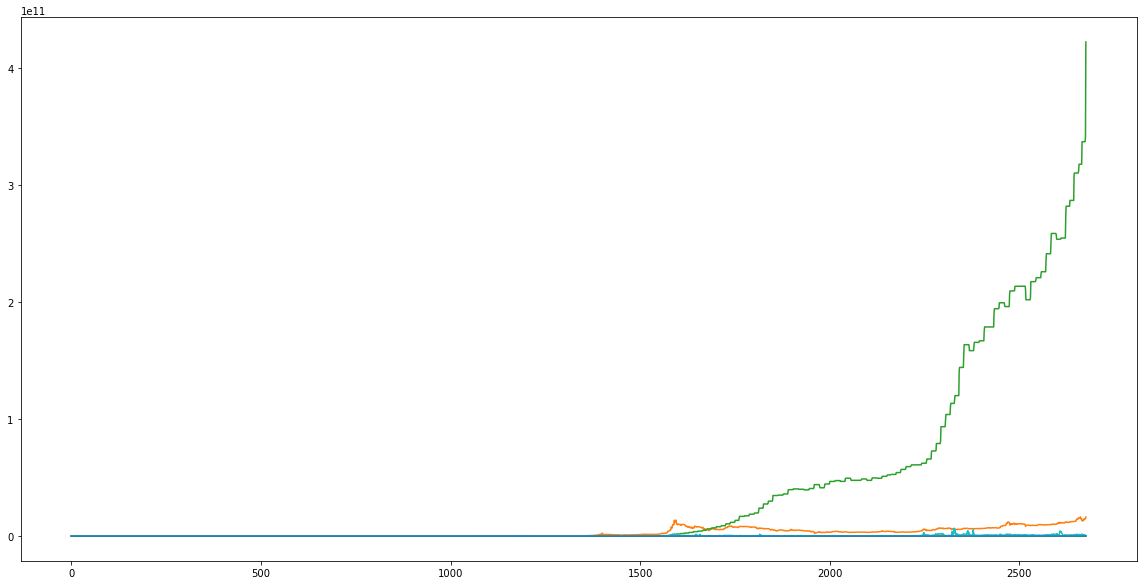

In [10]:
plt.plot(df_wo)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

#Con todas las metricas

X = df_wo[['AdrActCnt','BlkCnt','BlkSizeByte','BlkSizeMeanByte','CapMVRVCur','CapMrktCurUSD','CapRealUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','HashRate','IssContNtv','IssContPctAnn','IssContUSD','IssTotNtv','IssTotUSD','NVTAdj','NVTAdj90','PriceBTC','ROI1yr','ROI30d','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','TxTfrValNtv','TxTfrValUSD','VtyDayRet180d','VtyDayRet30d','VtyDayRet60d']]
y = df_wo['PriceUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size   = 0.8, random_state = 1234, shuffle = True)

In [11]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.027e+05
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:58:06   Log-Likelihood:                -2592.9
No. Observations:                 942   AIC:                             5258.
Df Residuals:                     906   BIC:                             5432.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AdrActCnt            3.52e-05    6.2

## Eliminamos las variables con p-value < 0.05 ya que no aportan de forma significativa al modelo

## Total **variables restantes 29**

In [12]:
df_regresion_wo = df_wo.drop(['BlkCnt', 'CapMVRVCur', 'FeeMeanNtv', 'FeeMedUSD', 'FeeMedNtv','HashRate','IssContPctAnn','IssTotNtv', 'PriceBTC','SplyExpFut10yrCMBI','TxTfrValMeanNtv','TxTfrValNtv','VtyDayRet60d'], axis=1)

In [11]:
x = df_wo.values
#x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_wo.columns
#df.columns = df_regresion_wo.columns

In [12]:
model = pca()
# Fit transform
out = model.fit_transform(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [11] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [4] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [13]:
print(out['topfeat'])

      PC          feature   loading  type
0    PC1           SplyFF  0.504304  best
1    PC2     VtyDayRet30d -0.782172  best
2    PC3     VtyDayRet30d  0.572222  best
3    PC4        FeeTotNtv -0.670141  best
4    PC5        FeeTotNtv  0.638423  best
5    PC6  TxTfrValMeanUSD  0.770686  best
6    PC7         DiffMean -0.689072  best
7    PC8         TxTfrCnt  0.705905  best
8    PC9      TxTfrValUSD -0.812514  best
9   PC10          SplyCur -0.700500  best
10  PC11    CapMrktCurUSD  0.684719  best
11   PC8        AdrActCnt -0.619333  weak
12  PC11         PriceUSD -0.622243  weak


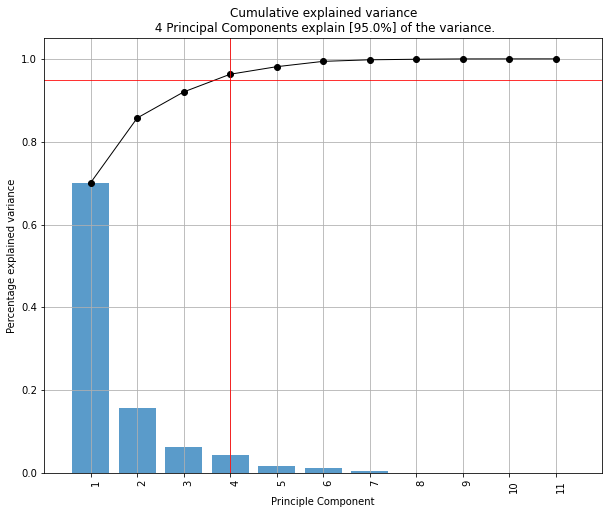

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1ed57c2f40>)

<Figure size 1440x720 with 0 Axes>

In [14]:
model.plot()

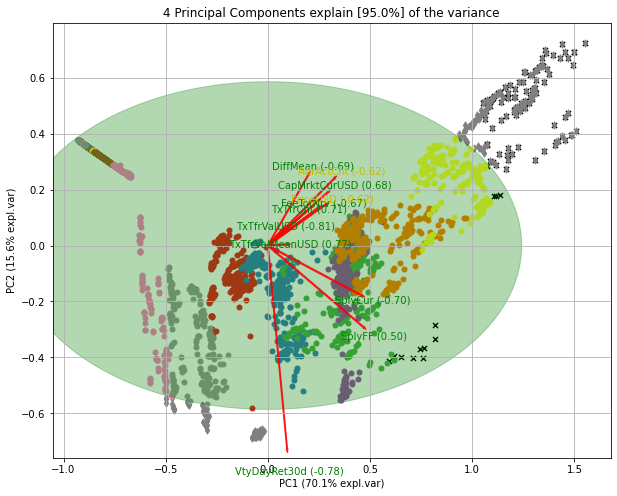

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1ed573ba90>)

In [15]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

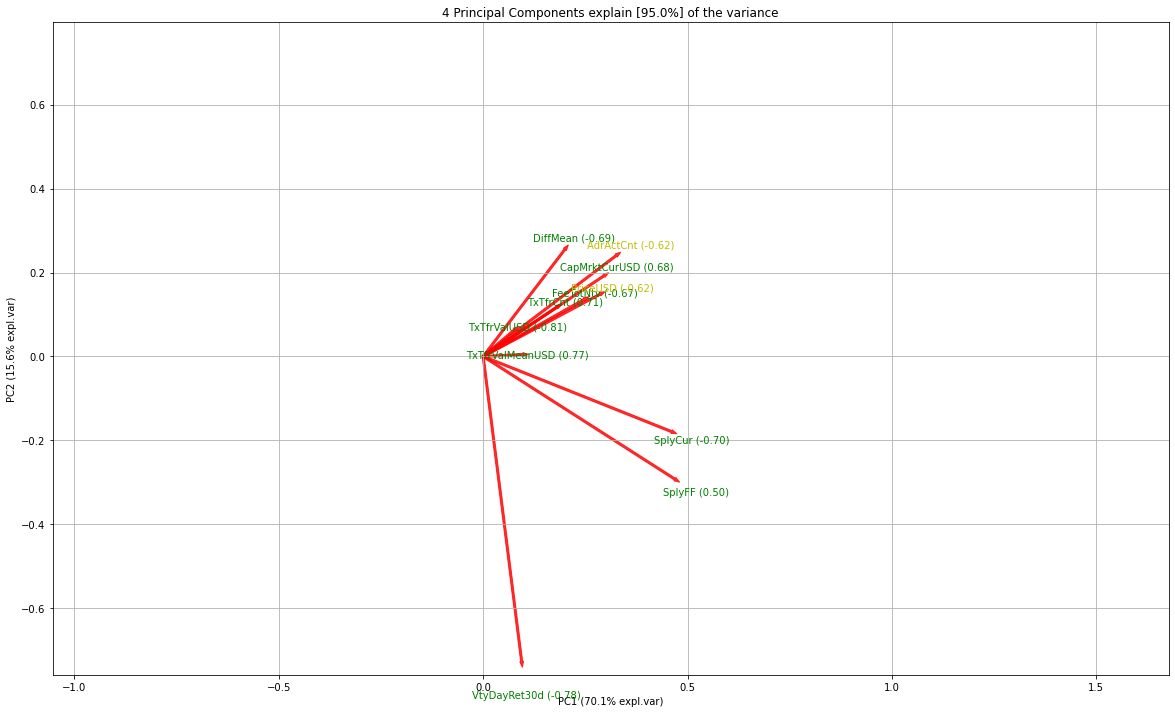

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1ed402d040>)

In [16]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

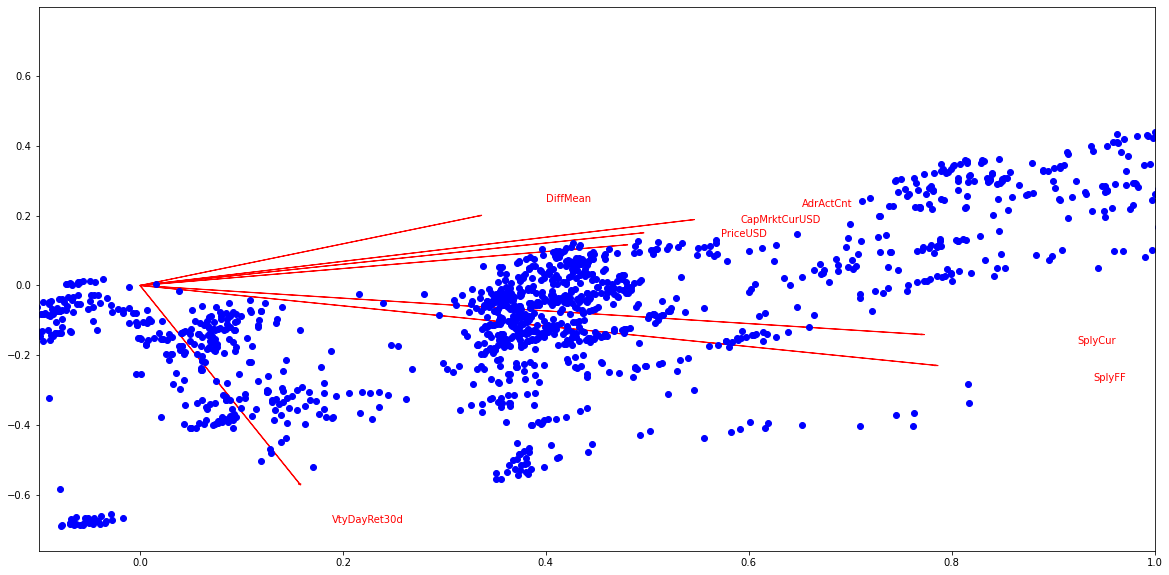

array(['AdrActCnt', 'CapMrktCurUSD', 'DiffMean', 'PriceUSD', 'SplyCur',
       'SplyFF', 'VtyDayRet30d'], dtype=object)

In [19]:
from sklearn.decomposition import PCA

n = len(df.columns)

pca = PCA(n_components = n)
pca.fit(df)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df)[:,0]
ys = pca.transform(df)[:,1]

#print(df.columns.values) #vector priceUSD
#print(xvector[3])
plt.xlim(-0.1,1)
lim = np.sqrt(xvector[3]**2 + yvector[3]**2)
feat = []

for i in range(len(xvector)):
    if(np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim):
    #if(xvector[i] >= lim or yvector[i]>=0.4):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                 list(df.columns.values)[i], color='r')
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')

plt.show()
df.columns.values[feat]

## Eliminamos las variables que tienen una norma menor al vector PriceUSD y con distinta dirección

## Total de **variables restantes 6**

In [20]:
df_red = df[df.columns.values[feat]].copy()
df_red = df_red.drop(['VtyDayRet30d'],axis =1)

In [23]:
#Con 29 variables

import dcor
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt = df_wo.apply(lambda col1: df_wo.apply(lambda col2: distcorr(col1, col2)))

pd.options.display.float_format = '{:,.2f}'.format
rslt

,AdrActCnt,CapMrktCurUSD,DiffMean,PriceUSD,FeeTotNtv,SplyCur,SplyFF,TxTfrCnt,TxTfrValMeanUSD,TxTfrValUSD,VtyDayRet30d
AdrActCnt,1.00,0.89,0.92,0.87,0.73,0.86,0.79,0.99,0.77,0.90,0.32
CapMrktCurUSD,0.89,1.00,0.78,1.00,0.61,0.81,0.77,0.87,0.84,0.86,0.30
DiffMean,0.92,0.78,1.00,0.74,0.73,0.69,0.59,0.90,0.63,0.84,0.23
PriceUSD,0.87,1.00,0.74,1.00,0.59,0.81,0.77,0.85,0.84,0.84,0.31
FeeTotNtv,0.73,0.61,0.73,0.59,1.00,0.77,0.76,0.76,0.62,0.68,0.35
SplyCur,0.86,0.81,0.69,0.81,0.77,1.00,0.99,0.88,0.78,0.74,0.56
SplyFF,0.79,0.77,0.59,0.77,0.76,0.99,1.00,0.83,0.77,0.68,0.57
TxTfrCnt,0.99,0.87,0.90,0.85,0.76,0.88,0.83,1.00,0.76,0.88,0.34
TxTfrValMeanUSD,0.77,0.84,0.63,0.84,0.62,0.78,0.77,0.76,1.00,0.88,0.36
TxTfrValUSD,0.90,0.86,0.84,0.84,0.68,0.74,0.68,0.88,0.88,1.00,0.25


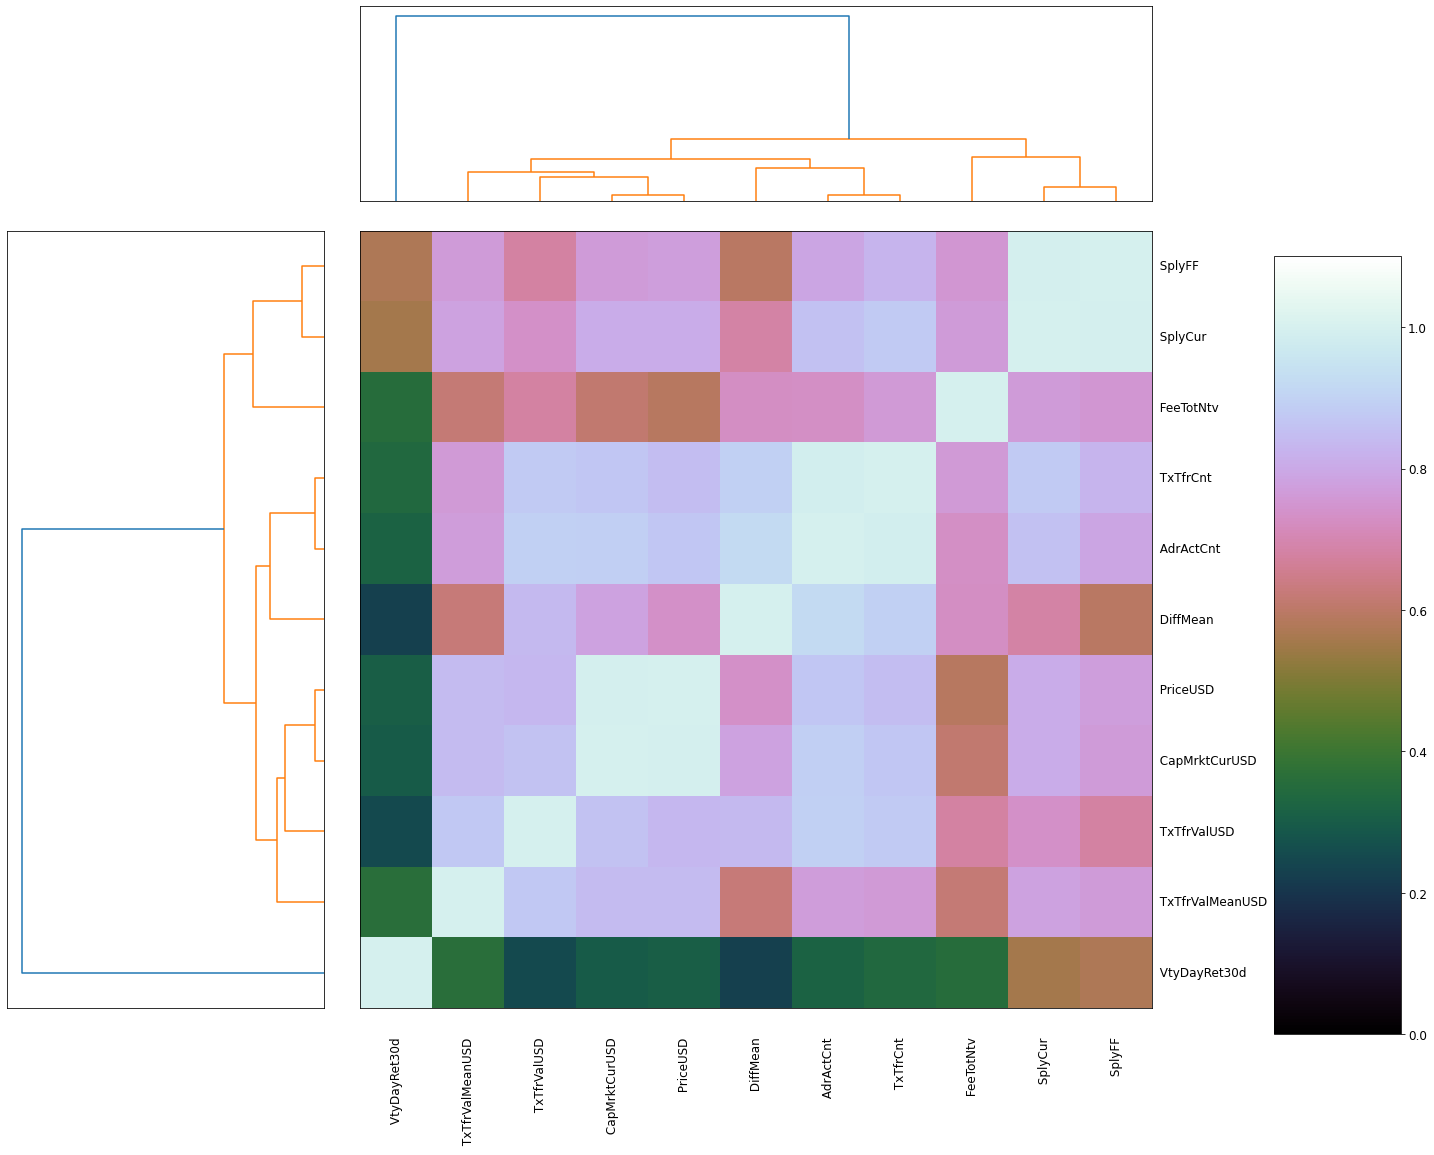

In [22]:
from biokit.viz import heatmap

df_wo.rename(index=str, columns={"Gross pay transform": "Gross pay tr"}, inplace=True)
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_wo.apply(lambda col1: df_wo.apply(lambda col2: distcorr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('BTC_dendograma.png', dpi = 100)